In [582]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

%matplotlib notebook

In [439]:
basename = 'S1A_EW_GRDM_1SDH_20190722T191423_20190722T191501_028234_033087_8DE6.zip.npz'
basename = 'S1A_EW_GRDM_1SDH_20190710T191422_20190710T191500_028059_032B41_785E.zip.npz'

n0 = np.load('s1a_npz/nesz_ESA_%s' % basename)['nesz_ESA']
s0 = np.load('s1a_npz/s0_%s' % basename)['s0']
n0n = np.load('s1a_npz/nesz_NERSC_%s' % basename)['nesz_NERSC']
inc = np.load('s1a_npz/inc_%s' % basename)['inc']

In [501]:
swath_bounds = [
    (19.55, 28.74),
    (28.74, 33.98),
    (33.98, 39.19),
    (39.19, 43.44),
    (43.44, 46.50)
]

$\sigma^0$ - total backscatter from S1 file;

$\sigma^0_R$ - real backscatter;

$N$ - annotated thermal noise (NESZ) from S1 file;

$N_R$ - real thermal noise;

$\sigma^0 = N_R + \sigma^0_R$

Let's assume that:

$N_R = k_1 + k_2 N$

and 

$\sigma^0_R = A + B cos (\alpha)$ (or for simplicity we will write $A + B \alpha$)

Therefore:

$\sigma^0 = k_1 + k_2 N + A + B \alpha$

We know $\sigma^0$, $N$ and $\alpha$, we can find $k_1, k_2, A, B$ if we solve a system of linear equations:

$B = Ax$

For this we need to form following matrices:

$B$ - values of $\sigma^0$ for all pixels in a subswath;

$A - [1, N, 1, \alpha]$ again values for all pixels in a subswath

$x$ - will become a vector of coefficients: $k_1$, $k_2$, $A$, $B$

In fact, $k_1$ and $A$ are free members and will cancel each other, so we need only one, let's say $A$.


In [605]:
swi = 1
cols = np.where((inc >= swath_bounds[swi][0]) * ((inc < swath_bounds[swi][1])))[0]
A = np.zeros((cols.size, 3))
A[:, 0] = n0[cols]
A[:, 1] = np.ones_like(cols)
A[:, 2] = np.cos(np.radians(inc[cols]))
B = s0[cols]
C = cols

Noise scaling coefficient:  1.0751995721916192


<IPython.core.display.Javascript object>


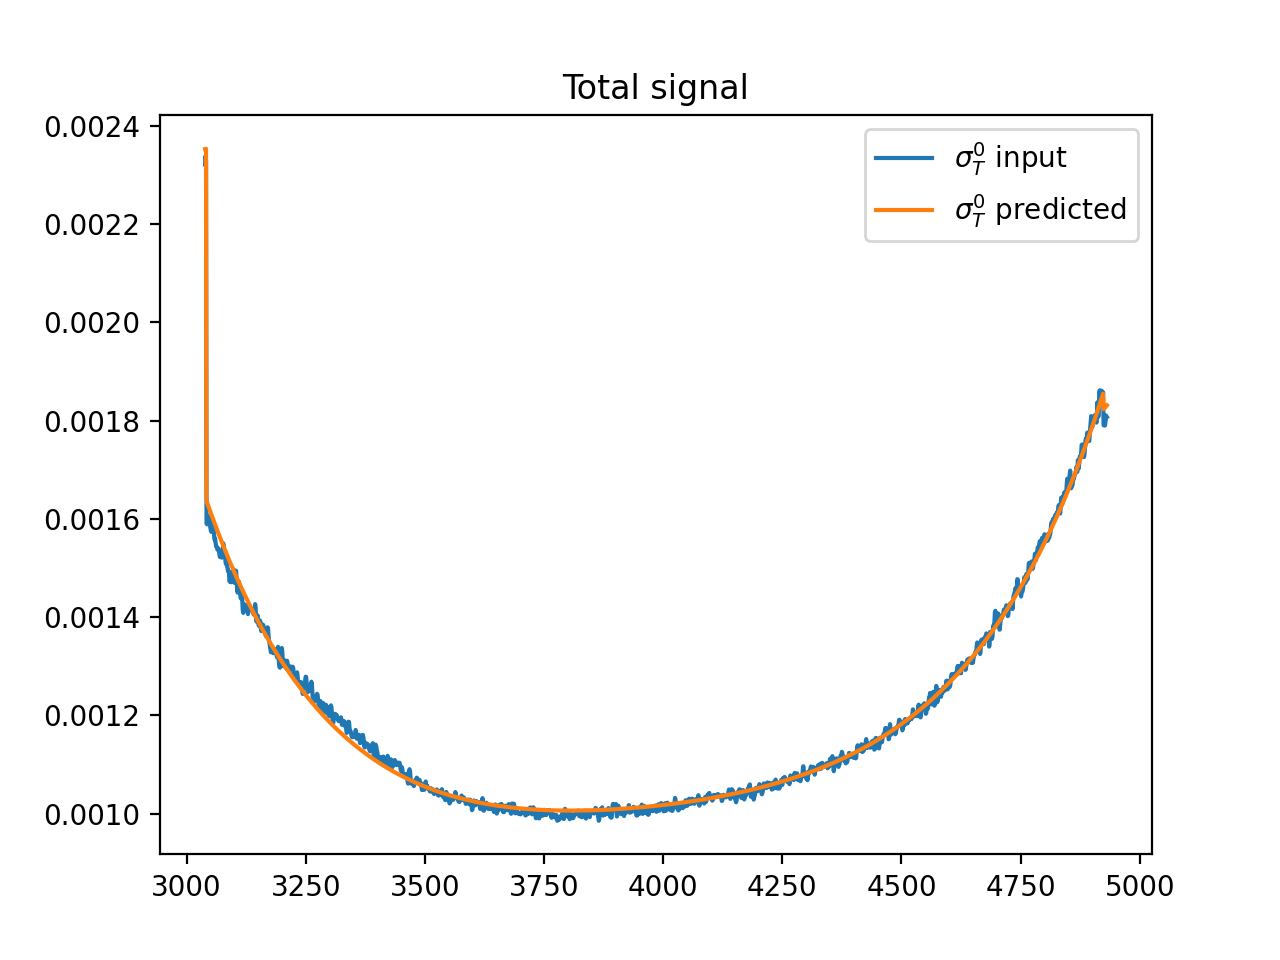

In [609]:
x = np.linalg.lstsq(A, B, rcond=None)[0]
print('Noise scaling coefficient: ', x[0])
Bs = np.dot(A,x)
plt.figure()
plt.plot(C, B, label='$\sigma^0_T$ input')
plt.plot(C, Bs, label='$\sigma^0_T$ predicted')
plt.legend()
plt.title('Total signal')
plt.show()

<IPython.core.display.Javascript object>


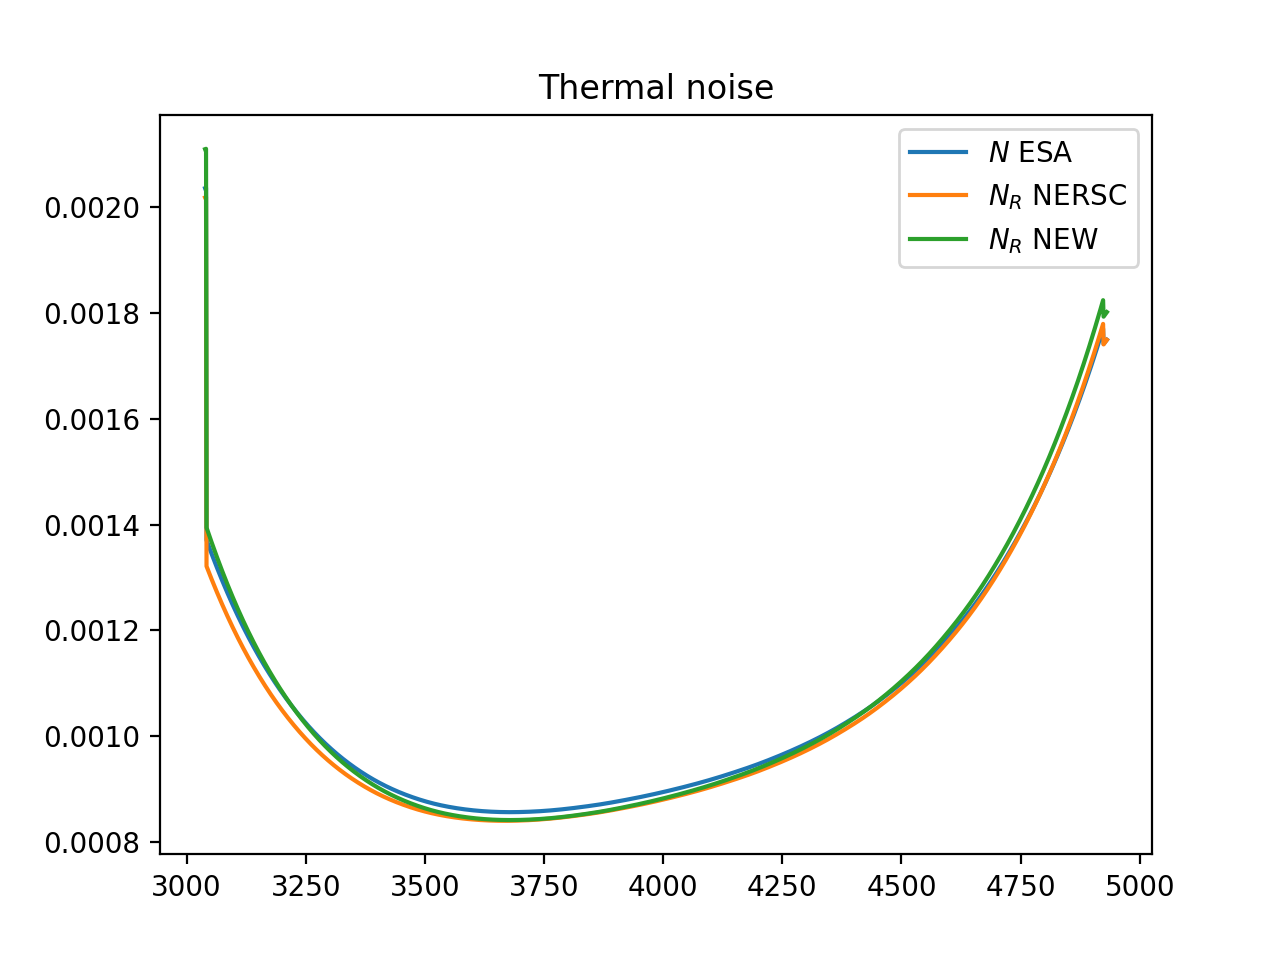

In [611]:
# scale the ESA noise with the new koefficient
n_scaled = A[:,0] * x[0]

# add offset equal to ESA mean offset
n_scaled = n_scaled - n_scaled.mean() + n0[C].mean()
plt.figure()
plt.plot(C, n0[C], label='$N$ ESA')
plt.plot(C, n0n[C], label='$N_R$ NERSC')
plt.plot(C, n_scaled, label='$N_R$ NEW')
plt.legend()
plt.title('Thermal noise')
plt.show()

<IPython.core.display.Javascript object>


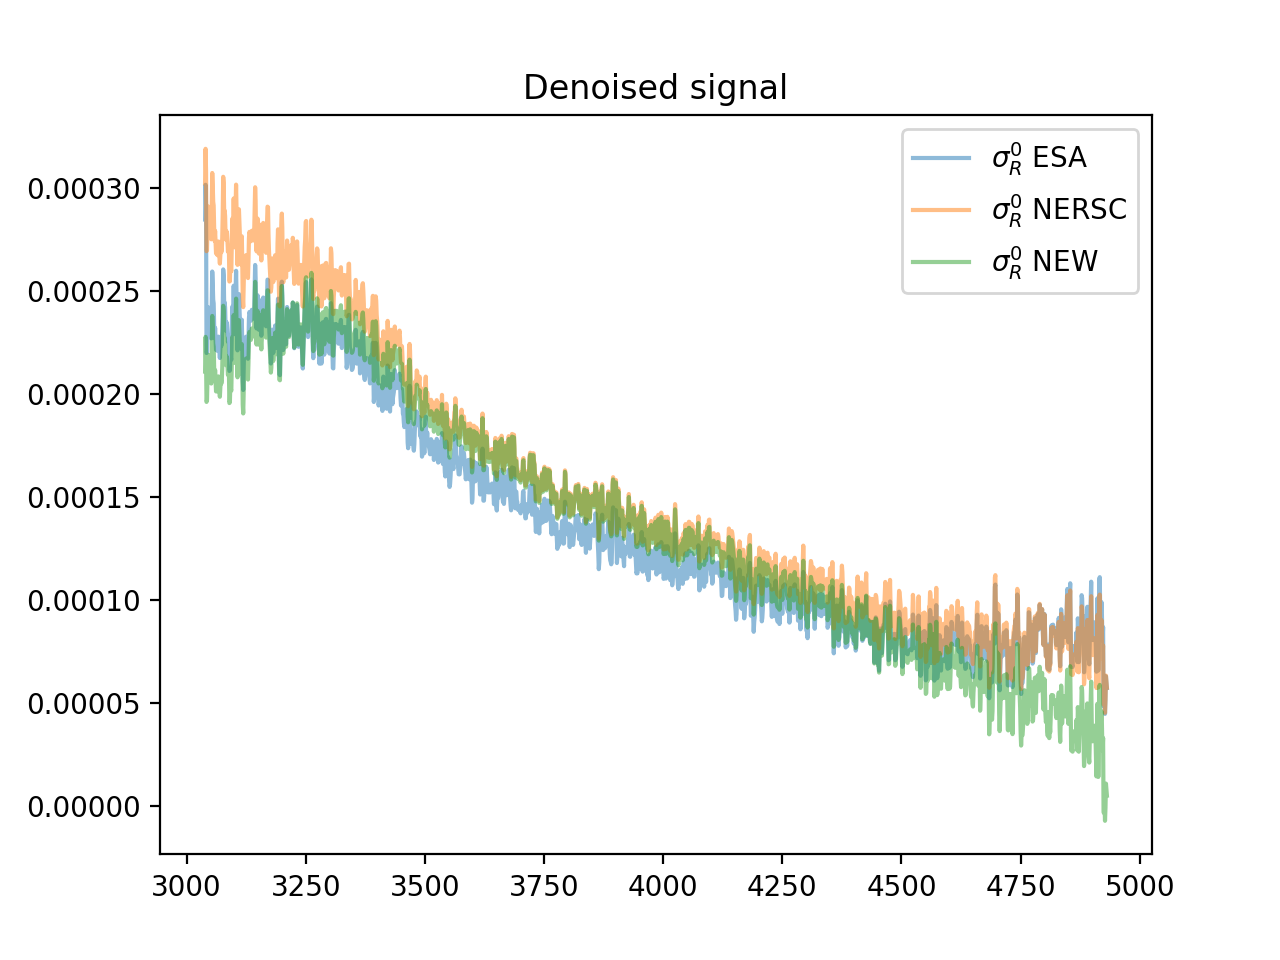

In [612]:
plt.figure()
plt.plot(C, s0[C] - n0[C], label='$\sigma^0_R$ ESA', alpha=0.5)
plt.plot(C, s0[C] - n0n[C], label='$\sigma^0_R$ NERSC', alpha=0.5)
plt.plot(C, s0[C] - n_scaled, label='$\sigma^0_R$ NEW', alpha=0.5)
plt.legend()
plt.title('Denoised signal')
plt.show()

The problem with the approach above, is that we don;t know the offset $k_1$.

We want to find this offset and at the same time constrain it so that difference between subswaths is minimal.

We cannot expand this approach to the entire range - the real signal ($\sigma^0_R$) is not just linearly depending on incidence angle, so $\sigma^0_R = A + B \alpha$ doesn't hold.

We can fit an individual model for each intersection of swaths. So for two swaths we will have these two equations:

$\sigma^0_1 = k_{11} + k_{21} N_1 + A + B \alpha$

$\sigma^0_2 = k_{12} + k_{22} N_2 + A + B \alpha$

Here $\sigma^0_1$ and $\sigma^0_2$ are values of total power for the first and second sub-swaths (same for $N_i$).
If we solve these equations then we will find different offset/scale coefficients $k_{11}, k_{12}$ / $k_{21}, k_{22}$. But the signal coefficients $A$ and $B$ will be the same! Because we assume that ate least for two subswaths we have the same linear signal.

We will need to form matrix A the following way:
```
1    N1   0   0     1   alpha1
1    N1   0   0     1   alpha1
.    .    .   .     .   .
.    .    .   .     .   .
1    N1   0   0     1   alpha1
0    0    1   N2    1   alpha2
0    0    1   N2    1   alpha2
.    .    .   .     .   .
.    .    .   .     .   .
0    0    1   N2    1   alpha2
```

The solution $x$ will contain values $[k_{11}, k_{12}, k_{21}, k_{22}, A, B]$


In the code below I generalize for N sub-swaths.
Each sub-swath I split in two parts. The left part is used with the previous subswath, the right - with the next one.

I also use second order polynomial for fitting the signal:

$\sigma^0_R = A + B \alpha + C \alpha^2$

And I also add dependece of scaled noise on averaged total signall:

$N_R = k_1 + k_2 N + k_3 \hat {\sigma^0_T}$

In [613]:
swaths = 2
preds = 3
preds_sig = 3
A1 = []
A2 = []
B = []
C = []
for swi in range(0,swaths):
    cols = np.where((inc >= swath_bounds[swi][0]) * ((inc < swath_bounds[swi][1])))[0]
    A1sub = np.zeros((cols.size, preds*swaths))
    A1sub[:, swi*preds+0] = np.ones_like(cols)
    A1sub[:, swi*preds+1] = n0[cols]
    A1sub[:, swi*preds+2] = uniform_filter1d(s0[cols], 500)
    A1.append(A1sub)
    B.append(s0[cols])
    C.append(cols)

    A2sub = np.zeros((cols.size, preds_sig*(swaths+1)))

    sw_mid_bound = (swath_bounds[swi][0] + swath_bounds[swi][1]) / 2
    cols1 = np.where((inc >= swath_bounds[swi][0]) * (inc < sw_mid_bound))[0]
    iswi = 0
    A2sub[:cols1.size, (swi+0)*preds_sig+0] = np.ones_like(cols1)
    A2sub[:cols1.size, (swi+0)*preds_sig+1] = np.cos(np.radians(inc[cols1]))
    A2sub[:cols1.size, (swi+0)*preds_sig+2] = np.cos(np.radians(inc[cols1])) ** 2

    cols2 = np.where((inc >= sw_mid_bound) * (inc < swath_bounds[swi][1]))[0]
    A2sub[cols1.size:, (swi+1)*preds_sig+0] = np.ones_like(cols2)
    A2sub[cols1.size:, (swi+1)*preds_sig+1] = np.cos(np.radians(inc[cols2]))
    A2sub[cols1.size:, (swi+1)*preds_sig+2] = np.cos(np.radians(inc[cols2])) ** 2
    
    A2.append(A2sub)

A1 = np.vstack(A1)
A2 = np.vstack(A2)
A = np.hstack([A1,A2])
B = np.hstack(B)
C = np.hstack(C)

<IPython.core.display.Javascript object>


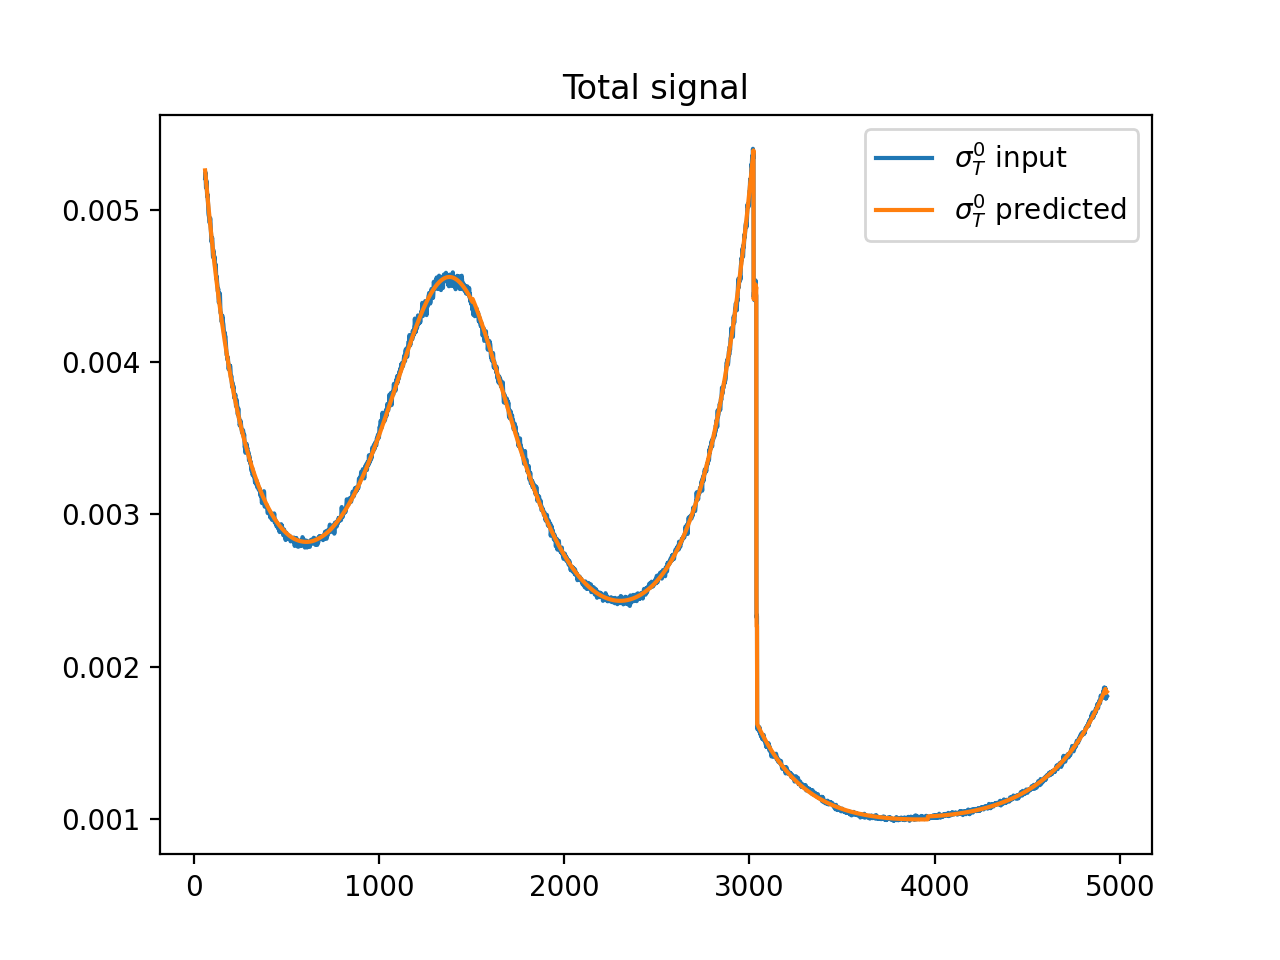

In [618]:
x = np.linalg.lstsq(A, B, rcond=None)[0]
Bs = np.dot(A,x)
plt.figure()
plt.plot(C, B, label='$\sigma^0_T$ input')
plt.plot(C, Bs, label='$\sigma^0_T$ predicted')
plt.legend()
plt.title('Total signal')
plt.show()

<IPython.core.display.Javascript object>


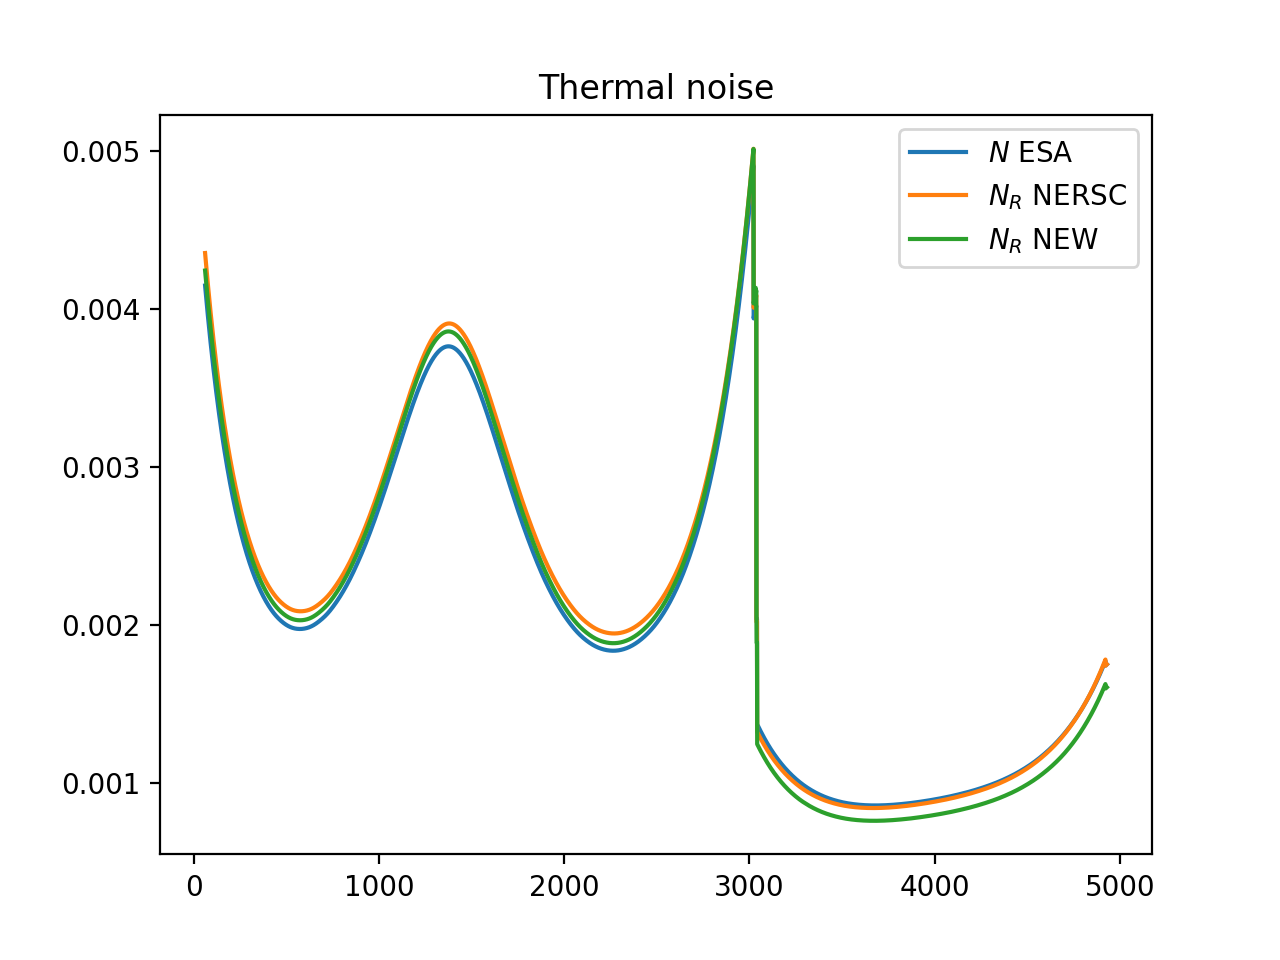

In [619]:
n_scaled = np.dot(A1, x[:(preds*swaths)])

n_scaled = n_scaled - n_scaled.mean() + n0[C].mean()
plt.figure()
plt.plot(C, n0[C], label='$N$ ESA')
plt.plot(C, n0n[C], label='$N_R$ NERSC')
plt.plot(C, n_scaled, label='$N_R$ NEW')
plt.legend()
plt.title('Thermal noise')
plt.show()

<IPython.core.display.Javascript object>


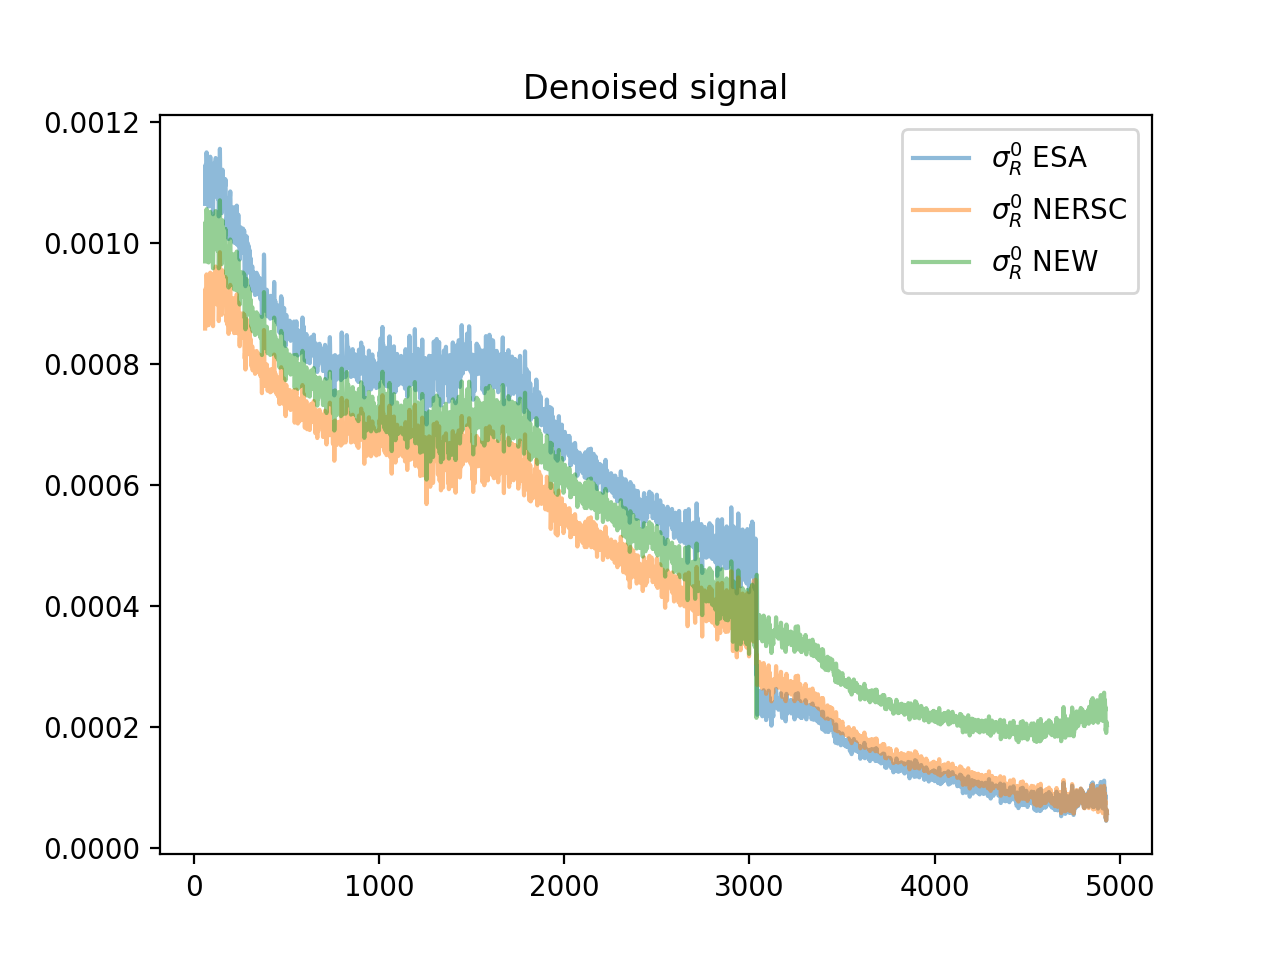

In [620]:
plt.figure()
plt.plot(C, s0[C] - n0[C], label='$\sigma^0_R$ ESA', alpha=0.5)
plt.plot(C, s0[C] - n0n[C], label='$\sigma^0_R$ NERSC', alpha=0.5)
plt.plot(C, s0[C] - n_scaled, label='$\sigma^0_R$ NEW', alpha=0.5)
plt.legend()
plt.title('Denoised signal')
plt.show()